In [4]:
!pip install -q segmentation_models_pytorch albumentations



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 4.7 MB/s eta 0:00:00


In [36]:
# Clear everything first
import gc
import torch
torch.cuda.empty_cache()
gc.collect()



import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from typing import Tuple, List, Dict, Optional

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
from torch.cuda.amp import autocast, GradScaler

import cv2
import albumentations as A
from albumentations.pytorch import ToTensorV2
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

import segmentation_models_pytorch as smp

import warnings
warnings.filterwarnings('ignore')

print("✅ Memory cleared, imports ready")

✅ Memory cleared, imports ready


In [51]:
class Config:
    SEED = 42
    DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    NUM_WORKERS = 2
    PIN_MEMORY = True

    # NEW DATASET PATH
    ROOT_DIR = "/kaggle/input/datasets/truthisneverlinear/childrens-dental-panoramic-radiographs-dataset/Dental_dataset/Childrens dental caries segmentation dataset"
    
    TRAIN_DIRS = [
        os.path.join(ROOT_DIR, "Train"),
        os.path.join(ROOT_DIR, "Supplemental content93")
    ]
    TEST_DIR = os.path.join(ROOT_DIR, "Test")

    IMG_SIZE = (512, 512)

    # Model config
    ENCODER = 'resnet34'
    ENCODER_WEIGHTS = 'imagenet'
    IN_CHANNELS = 3
    OUT_CLASSES = 1
    ATTENTION_TYPE = 'scse'

    EPOCHS = 60  # REDUCED from 100
    BATCH_SIZE = 6  # INCREASED from 4 (faster batches)
    ACCUMULATION_STEPS = 1  # REMOVED accumulation (faster)
    LEARNING_RATE = 1e-4
    USE_AMP = True

    @staticmethod
    def set_seed(seed=42):
        np.random.seed(seed)
        torch.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True

Config.set_seed()
print(f"✅ Config: Children's Dataset | ResNet34+SCSE | 60 epochs | Batch 6")

✅ Config: Children's Dataset | ResNet34+SCSE | 60 epochs | Batch 6


In [42]:
class DatasetLocator:
    @staticmethod
    def find_dataset():
        train_images, train_masks = [], []
        
        # Load Train + Supplemental data
        for train_dir in Config.TRAIN_DIRS:
            print(f"\n🔍 Processing: {os.path.basename(train_dir)}")
            img_dir = os.path.join(train_dir, "images")
            mask_dir = os.path.join(train_dir, "mask")
            
            # Get all image files
            img_files = []
            for ext in ['*.png', '*.jpg', '*.jpeg', '*.PNG', '*.JPG']:
                img_files.extend(glob.glob(os.path.join(img_dir, ext)))
            img_files = sorted(img_files)
            
            # Get all mask files
            mask_files = []
            for ext in ['*.png', '*.jpg', '*.jpeg', '*.PNG', '*.JPG']:
                mask_files.extend(glob.glob(os.path.join(mask_dir, ext)))
            mask_files = sorted(mask_files)
            
            # Build mask map - STRIP _pseudo suffix!
            mask_map = {}
            for m in mask_files:
                mask_name = os.path.splitext(os.path.basename(m))[0]
                # Remove _pseudo suffix
                if mask_name.endswith('_pseudo'):
                    mask_id = mask_name[:-7]  # Remove last 7 chars "_pseudo"
                else:
                    mask_id = mask_name
                mask_map[mask_id] = m
            
            # Match images to masks
            matched = 0
            for img_path in img_files:
                img_id = os.path.splitext(os.path.basename(img_path))[0]
                if img_id in mask_map:
                    train_images.append(img_path)
                    train_masks.append(mask_map[img_id])
                    matched += 1
            
            print(f"   ✅ Matched: {matched} pairs")
        
        # Load Test data
        print(f"\n🔍 Processing: Test")
        test_img_dir = os.path.join(Config.TEST_DIR, "images")
        test_mask_dir = os.path.join(Config.TEST_DIR, "mask")
        
        test_img_files = []
        for ext in ['*.png', '*.jpg', '*.jpeg', '*.PNG', '*.JPG']:
            test_img_files.extend(glob.glob(os.path.join(test_img_dir, ext)))
        test_img_files = sorted(test_img_files)
        
        test_mask_files = []
        for ext in ['*.png', '*.jpg', '*.jpeg', '*.PNG', '*.JPG']:
            test_mask_files.extend(glob.glob(os.path.join(test_mask_dir, ext)))
        test_mask_files = sorted(test_mask_files)
        
        # Build test mask map - STRIP _pseudo suffix!
        test_mask_map = {}
        for m in test_mask_files:
            mask_name = os.path.splitext(os.path.basename(m))[0]
            if mask_name.endswith('_pseudo'):
                mask_id = mask_name[:-7]
            else:
                mask_id = mask_name
            test_mask_map[mask_id] = m
        
        test_images, test_masks = [], []
        matched = 0
        for img_path in test_img_files:
            img_id = os.path.splitext(os.path.basename(img_path))[0]
            if img_id in test_mask_map:
                test_images.append(img_path)
                test_masks.append(test_mask_map[img_id])
                matched += 1
        
        print(f"   ✅ Matched: {matched} pairs")
        
        print(f"\n{'='*60}")
        print(f"✓ Train (Train+Supplemental): {len(train_images)} images")
        print(f"✓ Test (Validation):          {len(test_images)} images")
        print(f"✓ TOTAL:                      {len(train_images) + len(test_images)} images")
        print(f"{'='*60}")
        
        return train_images, train_masks, test_images, test_masks

train_imgs, train_masks, val_imgs, val_masks = DatasetLocator.find_dataset()


🔍 Processing: Train
   ✅ Matched: 70 pairs

🔍 Processing: Supplemental content93
   ✅ Matched: 93 pairs

🔍 Processing: Test
   ✅ Matched: 30 pairs

✓ Train (Train+Supplemental): 163 images
✓ Test (Validation):          30 images
✓ TOTAL:                      193 images


In [58]:
class DentalCariesDataset(Dataset):
    def __init__(self, image_paths, mask_paths, transform=None, img_size=(512, 512)):
        self.image_paths = image_paths
        self.mask_paths  = mask_paths
        self.transform   = transform
        self.img_size    = img_size

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        image = cv2.imread(self.image_paths[idx])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask  = cv2.imread(self.mask_paths[idx], cv2.IMREAD_GRAYSCALE)

        image = cv2.resize(image, self.img_size, interpolation=cv2.INTER_LINEAR)
        mask  = cv2.resize(mask,  self.img_size, interpolation=cv2.INTER_NEAREST)
        
        # FIXED: Use mask > 0 instead of mask > 127
        # Teeth are marked with values like 106, background is 0
        mask  = (mask > 0).astype(np.float32)

        if self.transform:
            aug   = self.transform(image=image, mask=mask)
            image = aug['image']
            mask  = aug['mask']

        if isinstance(image, torch.Tensor):
            image = image.float()

        if isinstance(mask, torch.Tensor):
            if mask.ndim == 2:
                mask = mask.unsqueeze(0)
        else:
            mask = torch.from_numpy(mask).unsqueeze(0).float()

        return {'image': image, 'mask': mask}

In [59]:
class AugmentationPipeline:

    @staticmethod
    def get_train_transforms():
        return A.Compose([
            A.Resize(512, 512),
            A.RandomResizedCrop(size=(512, 512), scale=(0.5, 1.0), ratio=(0.75, 1.3), p=0.6),
            A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=1.0),
            A.HorizontalFlip(p=0.5),
            A.VerticalFlip(p=0.2),
            A.Affine(translate_percent={'x': 0.12, 'y': 0.12}, rotate=(-25, 25),
                     scale=(0.8, 1.2), p=0.75),
            A.ElasticTransform(alpha=150, sigma=7, p=0.5),
            A.GridDistortion(num_steps=6, distort_limit=0.35, p=0.35),
            A.RandomBrightnessContrast(brightness_limit=0.4, contrast_limit=0.4, p=0.75),
            A.RandomGamma(gamma_limit=(65, 135), p=0.6),
            A.GaussianBlur(blur_limit=(3, 7), p=0.35),
            A.GaussNoise(p=0.35),
            A.Sharpen(alpha=(0.2, 0.6), lightness=(0.5, 1.0), p=0.45),
            A.CoarseDropout(max_holes=5, max_height=60, max_width=60, fill_value=0, p=0.35),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

    @staticmethod
    def get_val_transforms():
        return A.Compose([
            A.Resize(512, 512),
            A.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), p=1.0),
            A.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
            ToTensorV2()
        ])

In [60]:
class RepeatedDataset(Dataset):
    def __init__(self, base_dataset, repeat=3):  # REDUCED from 5 to 3
        self.base = base_dataset
        self.repeat = repeat

    def __len__(self):
        return len(self.base) * self.repeat

    def __getitem__(self, idx):
        return self.base[idx % len(self.base)]

train_base = DentalCariesDataset(train_imgs, train_masks,
                                 transform=AugmentationPipeline.get_train_transforms())
val_dataset = DentalCariesDataset(val_imgs, val_masks,
                                  transform=AugmentationPipeline.get_val_transforms())

train_dataset = RepeatedDataset(train_base, repeat=3)  # 163 * 3 = 489

print(f"✅ Train size: {len(train_dataset)} (163 × 3)")
print(f"   Val size: {len(val_dataset)}")

train_loader = DataLoader(train_dataset, batch_size=Config.BATCH_SIZE, shuffle=True,
                          num_workers=Config.NUM_WORKERS, pin_memory=Config.PIN_MEMORY)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False,  # Increased val batch
                        num_workers=Config.NUM_WORKERS, pin_memory=Config.PIN_MEMORY)

print(f"   Batches/epoch: {len(train_loader)} (was 204, now ~82)")

✅ Train size: 489 (163 × 3)
   Val size: 30
   Batches/epoch: 82 (was 204, now ~82)


In [61]:
def build_model():
    model = smp.UnetPlusPlus(
        encoder_name=Config.ENCODER,
        encoder_weights=Config.ENCODER_WEIGHTS,
        in_channels=Config.IN_CHANNELS,
        classes=Config.OUT_CLASSES,
        decoder_attention_type=Config.ATTENTION_TYPE,
        activation=None
    )
    return model

model = build_model()
model.to(Config.DEVICE)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"✅ UNet++ ResNet34 + SCSE on {Config.DEVICE}")
print(f"   Total params: {total_params/1e6:.2f}M | Trainable: {trainable_params/1e6:.2f}M")

torch.cuda.empty_cache()

✅ UNet++ ResNet34 + SCSE on cuda
   Total params: 26.28M | Trainable: 26.28M


In [62]:
bce_loss = nn.BCEWithLogitsLoss(
    pos_weight=torch.tensor([200.0]).to(Config.DEVICE)
)
dice_loss = smp.losses.DiceLoss(mode='binary', from_logits=True)

def criterion(outputs, masks):
    return 0.65 * dice_loss(outputs, masks) + 0.35 * bce_loss(outputs, masks)

optimizer = torch.optim.AdamW(model.parameters(), lr=Config.LEARNING_RATE, weight_decay=1e-4)

scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=1.2e-3,
    epochs=Config.EPOCHS,
    steps_per_epoch=len(train_loader),
    pct_start=0.08,
    anneal_strategy='cos',
    div_factor=12,
    final_div_factor=150
)

scaler = GradScaler()
print("✅ Loss: 65% Dice + 35% BCE(pos_weight=200)")
print("   Optimizer: AdamW | Scheduler: OneCycleLR(max_lr=1.2e-3)")

✅ Loss: 65% Dice + 35% BCE(pos_weight=200)
   Optimizer: AdamW | Scheduler: OneCycleLR(max_lr=1.2e-3)


In [63]:
def train_one_epoch(loader, model, optimizer, criterion, scaler, scheduler):
    model.train()
    running_loss = 0
    loop = tqdm(loader, desc="Training", leave=False)

    for i, batch in enumerate(loop):
        images = batch['image'].to(Config.DEVICE)
        masks  = batch['mask'].to(Config.DEVICE)

        optimizer.zero_grad()
        
        with autocast():
            outputs = model(images)
            loss    = criterion(outputs, masks)

        scaler.scale(loss).backward()
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()

        running_loss += loss.item()
        loop.set_postfix(loss=loss.item())

        if i % 20 == 0:  # Less frequent cache clearing
            torch.cuda.empty_cache()

    return running_loss / len(loader)

In [64]:
def validate_one_epoch(loader, model, threshold=0.5):
    model.eval()
    total_tp = total_fp = total_tn = total_fn = 0

    with torch.no_grad():
        for batch in loader:
            images = batch['image'].to(Config.DEVICE)
            masks  = batch['mask'].to(Config.DEVICE)

            with autocast():
                outputs = model(images)

            preds = (torch.sigmoid(outputs) > threshold).float()
            total_tp += ((preds == 1) & (masks == 1)).sum().item()
            total_fp += ((preds == 1) & (masks == 0)).sum().item()
            total_tn += ((preds == 0) & (masks == 0)).sum().item()
            total_fn += ((preds == 0) & (masks == 1)).sum().item()

            torch.cuda.empty_cache()

    eps = 1e-6
    iou     = total_tp / (total_tp + total_fp + total_fn + eps)
    recall  = total_tp / (total_tp + total_fn + eps)
    spec    = total_tn / (total_tn + total_fp + eps)
    return iou, recall, spec

In [65]:
print(f"🚀 TARGET: IoU 0.60+ | New Dataset: 193 images (163 train + 30 val)")
print(f"   Training: 163×5=815 samples/epoch | Batch 4×2 = 8 effective\n")

best_val_iou = 0.0
patience = 30
no_improve = 0

# IMPORTANT: Save every 10 epochs as backup!
for epoch in range(Config.EPOCHS):
    train_loss = train_one_epoch(train_loader, model, optimizer,
                                 criterion, scaler, scheduler)
    val_iou, val_recall, val_spec = validate_one_epoch(val_loader, model)

    print(f"Epoch {epoch+1:3d}/{Config.EPOCHS} | "
          f"Loss: {train_loss:.4f} | "
          f"IoU: {val_iou:.4f} | "
          f"Recall: {val_recall:.4f} | "
          f"Spec: {val_spec:.4f}")

    # Save best model
    if val_iou > best_val_iou:
        improvement = val_iou - best_val_iou
        print(f"  🔥 Improvement! ({best_val_iou:.4f} → {val_iou:.4f}, +{improvement:.4f}) Saving...")
        
        # Save to working directory (Kaggle can access this)
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'iou': val_iou,
        }, "/kaggle/working/best_model.pth")
        
        best_val_iou = val_iou
        no_improve = 0
        
        if val_iou >= 0.60:
            print(f"  🎉🎉🎉 TARGET ACHIEVED! IoU {val_iou:.4f} >= 0.60! 🎉🎉🎉")
    else:
        no_improve += 1
        if no_improve >= patience:
            print(f"  ⏹️ Early stop at epoch {epoch+1}. Best IoU: {best_val_iou:.4f}")
            break

    # Backup save every 10 epochs
    if (epoch + 1) % 10 == 0:
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'iou': val_iou,
        }, f"/kaggle/working/checkpoint_epoch_{epoch+1}.pth")
        print(f"  💾 Checkpoint saved: epoch {epoch+1}")

    print("-" * 70)
    torch.cuda.empty_cache()
    gc.collect()

print(f"\n{'='*70}")
print(f"🏆 TRAINING COMPLETE | Best IoU: {best_val_iou:.4f}")
print(f"{'='*70}")

🚀 TARGET: IoU 0.60+ | New Dataset: 193 images (163 train + 30 val)
   Training: 163×5=815 samples/epoch | Batch 4×2 = 8 effective



Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch   1/60 | Loss: 8.8845 | IoU: 0.6773 | Recall: 0.9887 | Spec: 0.9084
  🔥 Improvement! (0.0000 → 0.6773, +0.6773) Saving...
  🎉🎉🎉 TARGET ACHIEVED! IoU 0.6773 >= 0.60! 🎉🎉🎉
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch   2/60 | Loss: 3.6833 | IoU: 0.3424 | Recall: 1.0000 | Spec: 0.6176
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch   3/60 | Loss: 1.5942 | IoU: 0.2812 | Recall: 1.0000 | Spec: 0.4908
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch   4/60 | Loss: 1.2626 | IoU: 0.4993 | Recall: 0.9965 | Spec: 0.8017
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch   5/60 | Loss: 0.9975 | IoU: 0.5614 | Recall: 0.9989 | Spec: 0.8448
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch   6/60 | Loss: 0.8542 | IoU: 0.5189 | Recall: 0.9996 | Spec: 0.8156
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch   7/60 | Loss: 0.8295 | IoU: 0.6161 | Recall: 0.9985 | Spec: 0.8764
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch   8/60 | Loss: 0.7063 | IoU: 0.5864 | Recall: 0.9992 | Spec: 0.8598
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch   9/60 | Loss: 0.6802 | IoU: 0.5889 | Recall: 0.9998 | Spec: 0.8610
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  10/60 | Loss: 0.6383 | IoU: 0.6190 | Recall: 0.9994 | Spec: 0.8776
  💾 Checkpoint saved: epoch 10
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  11/60 | Loss: 0.6444 | IoU: 0.6039 | Recall: 0.9995 | Spec: 0.8695
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  12/60 | Loss: 0.6454 | IoU: 0.5753 | Recall: 0.9999 | Spec: 0.8530
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  13/60 | Loss: 0.6212 | IoU: 0.6434 | Recall: 0.9990 | Spec: 0.8899
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  14/60 | Loss: 0.5937 | IoU: 0.6347 | Recall: 0.9996 | Spec: 0.8855
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  15/60 | Loss: 0.5548 | IoU: 0.6139 | Recall: 0.9998 | Spec: 0.8748
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  16/60 | Loss: 0.5919 | IoU: 0.6136 | Recall: 0.9997 | Spec: 0.8747
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  17/60 | Loss: 0.5496 | IoU: 0.6220 | Recall: 0.9999 | Spec: 0.8790
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  18/60 | Loss: 0.5938 | IoU: 0.6395 | Recall: 0.9998 | Spec: 0.8878
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  19/60 | Loss: 0.5266 | IoU: 0.6111 | Recall: 0.9998 | Spec: 0.8733
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  20/60 | Loss: 0.5378 | IoU: 0.6495 | Recall: 0.9997 | Spec: 0.8926
  💾 Checkpoint saved: epoch 20
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  21/60 | Loss: 0.5291 | IoU: 0.6477 | Recall: 0.9996 | Spec: 0.8918
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  22/60 | Loss: 0.5136 | IoU: 0.6152 | Recall: 0.9998 | Spec: 0.8755
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  23/60 | Loss: 0.5058 | IoU: 0.6602 | Recall: 0.9995 | Spec: 0.8976
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  24/60 | Loss: 0.4918 | IoU: 0.6350 | Recall: 0.9997 | Spec: 0.8856
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  25/60 | Loss: 0.4926 | IoU: 0.6608 | Recall: 0.9994 | Spec: 0.8980
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  26/60 | Loss: 0.4916 | IoU: 0.6141 | Recall: 0.9999 | Spec: 0.8749
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  27/60 | Loss: 0.4779 | IoU: 0.6682 | Recall: 0.9995 | Spec: 0.9013
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  28/60 | Loss: 0.4631 | IoU: 0.6791 | Recall: 0.9989 | Spec: 0.9062
  🔥 Improvement! (0.6773 → 0.6791, +0.0018) Saving...
  🎉🎉🎉 TARGET ACHIEVED! IoU 0.6791 >= 0.60! 🎉🎉🎉
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  29/60 | Loss: 0.4559 | IoU: 0.6744 | Recall: 0.9993 | Spec: 0.9040
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  30/60 | Loss: 0.4621 | IoU: 0.6624 | Recall: 0.9995 | Spec: 0.8987
  💾 Checkpoint saved: epoch 30
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  31/60 | Loss: 0.4575 | IoU: 0.6822 | Recall: 0.9990 | Spec: 0.9075
  🔥 Improvement! (0.6791 → 0.6822, +0.0031) Saving...
  🎉🎉🎉 TARGET ACHIEVED! IoU 0.6822 >= 0.60! 🎉🎉🎉
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  32/60 | Loss: 0.4542 | IoU: 0.6886 | Recall: 0.9986 | Spec: 0.9103
  🔥 Improvement! (0.6822 → 0.6886, +0.0064) Saving...
  🎉🎉🎉 TARGET ACHIEVED! IoU 0.6886 >= 0.60! 🎉🎉🎉
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  33/60 | Loss: 0.4500 | IoU: 0.6727 | Recall: 0.9993 | Spec: 0.9033
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  34/60 | Loss: 0.4573 | IoU: 0.7036 | Recall: 0.9979 | Spec: 0.9167
  🔥 Improvement! (0.6886 → 0.7036, +0.0151) Saving...
  🎉🎉🎉 TARGET ACHIEVED! IoU 0.7036 >= 0.60! 🎉🎉🎉
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  35/60 | Loss: 0.4313 | IoU: 0.6883 | Recall: 0.9988 | Spec: 0.9101
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  36/60 | Loss: 0.4170 | IoU: 0.6758 | Recall: 0.9990 | Spec: 0.9047
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  37/60 | Loss: 0.4180 | IoU: 0.6889 | Recall: 0.9986 | Spec: 0.9105
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  38/60 | Loss: 0.4128 | IoU: 0.6900 | Recall: 0.9987 | Spec: 0.9109
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  39/60 | Loss: 0.4125 | IoU: 0.6995 | Recall: 0.9984 | Spec: 0.9149
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  40/60 | Loss: 0.4097 | IoU: 0.6992 | Recall: 0.9982 | Spec: 0.9148
  💾 Checkpoint saved: epoch 40
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  41/60 | Loss: 0.4028 | IoU: 0.6995 | Recall: 0.9987 | Spec: 0.9148
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  42/60 | Loss: 0.4193 | IoU: 0.7003 | Recall: 0.9982 | Spec: 0.9153
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  43/60 | Loss: 0.3992 | IoU: 0.6967 | Recall: 0.9986 | Spec: 0.9137
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  44/60 | Loss: 0.3975 | IoU: 0.6934 | Recall: 0.9988 | Spec: 0.9123
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  45/60 | Loss: 0.3921 | IoU: 0.7016 | Recall: 0.9981 | Spec: 0.9158
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  46/60 | Loss: 0.3989 | IoU: 0.6968 | Recall: 0.9983 | Spec: 0.9138
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  47/60 | Loss: 0.3968 | IoU: 0.7005 | Recall: 0.9981 | Spec: 0.9154
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  48/60 | Loss: 0.3911 | IoU: 0.6991 | Recall: 0.9984 | Spec: 0.9147
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  49/60 | Loss: 0.3839 | IoU: 0.7024 | Recall: 0.9981 | Spec: 0.9162
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  50/60 | Loss: 0.3897 | IoU: 0.7010 | Recall: 0.9983 | Spec: 0.9155
  💾 Checkpoint saved: epoch 50
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  51/60 | Loss: 0.3844 | IoU: 0.7019 | Recall: 0.9983 | Spec: 0.9159
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  52/60 | Loss: 0.3783 | IoU: 0.7026 | Recall: 0.9984 | Spec: 0.9162
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  53/60 | Loss: 0.3773 | IoU: 0.7078 | Recall: 0.9978 | Spec: 0.9184
  🔥 Improvement! (0.7036 → 0.7078, +0.0042) Saving...
  🎉🎉🎉 TARGET ACHIEVED! IoU 0.7078 >= 0.60! 🎉🎉🎉
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  54/60 | Loss: 0.3868 | IoU: 0.7030 | Recall: 0.9984 | Spec: 0.9163
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  55/60 | Loss: 0.3833 | IoU: 0.7086 | Recall: 0.9979 | Spec: 0.9187
  🔥 Improvement! (0.7078 → 0.7086, +0.0008) Saving...
  🎉🎉🎉 TARGET ACHIEVED! IoU 0.7086 >= 0.60! 🎉🎉🎉
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  56/60 | Loss: 0.3846 | IoU: 0.7073 | Recall: 0.9980 | Spec: 0.9181
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  57/60 | Loss: 0.3762 | IoU: 0.7091 | Recall: 0.9979 | Spec: 0.9189
  🔥 Improvement! (0.7086 → 0.7091, +0.0005) Saving...
  🎉🎉🎉 TARGET ACHIEVED! IoU 0.7091 >= 0.60! 🎉🎉🎉
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  58/60 | Loss: 0.3822 | IoU: 0.7063 | Recall: 0.9981 | Spec: 0.9177
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  59/60 | Loss: 0.3726 | IoU: 0.7067 | Recall: 0.9980 | Spec: 0.9179
----------------------------------------------------------------------


Training:   0%|          | 0/82 [00:00<?, ?it/s]

Epoch  60/60 | Loss: 0.3781 | IoU: 0.7062 | Recall: 0.9980 | Spec: 0.9177
  💾 Checkpoint saved: epoch 60
----------------------------------------------------------------------

🏆 TRAINING COMPLETE | Best IoU: 0.7091


🔄 Loading the best model


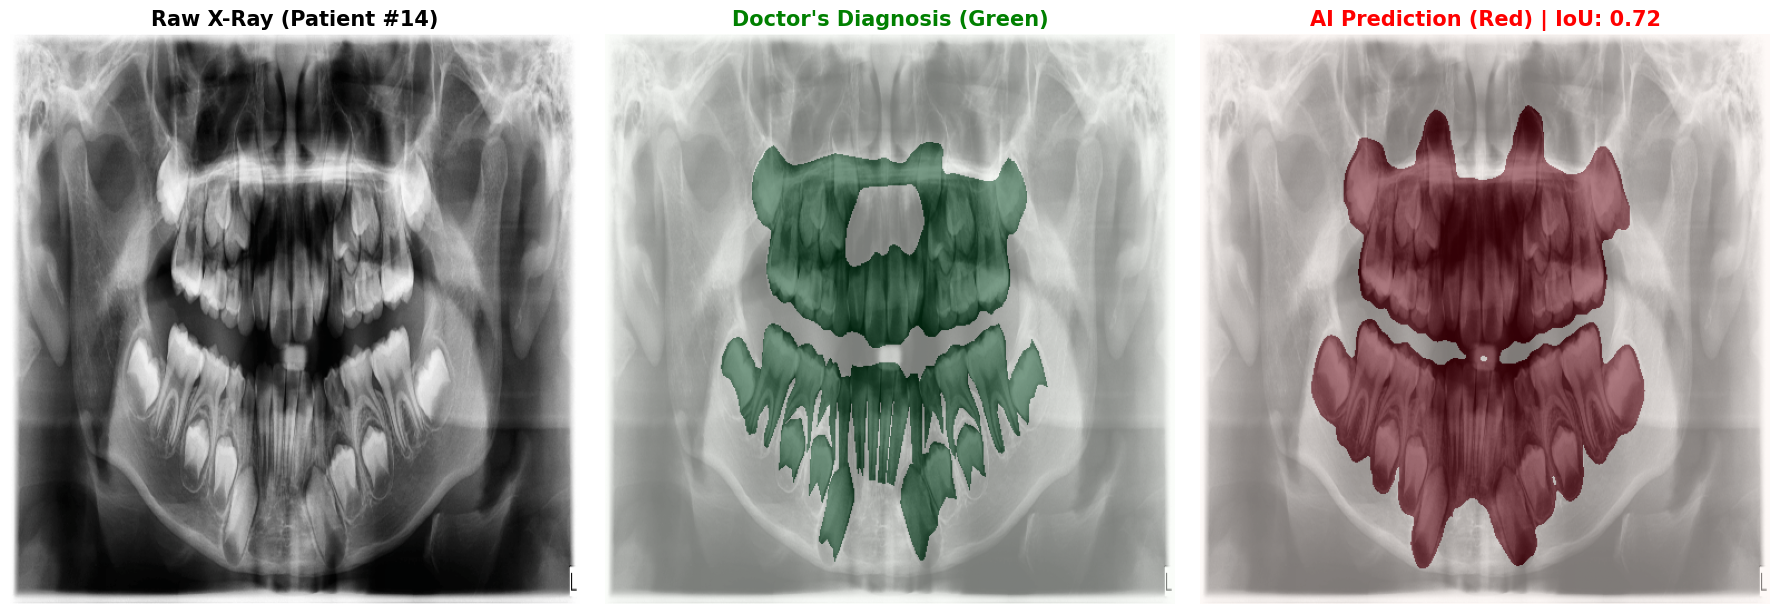

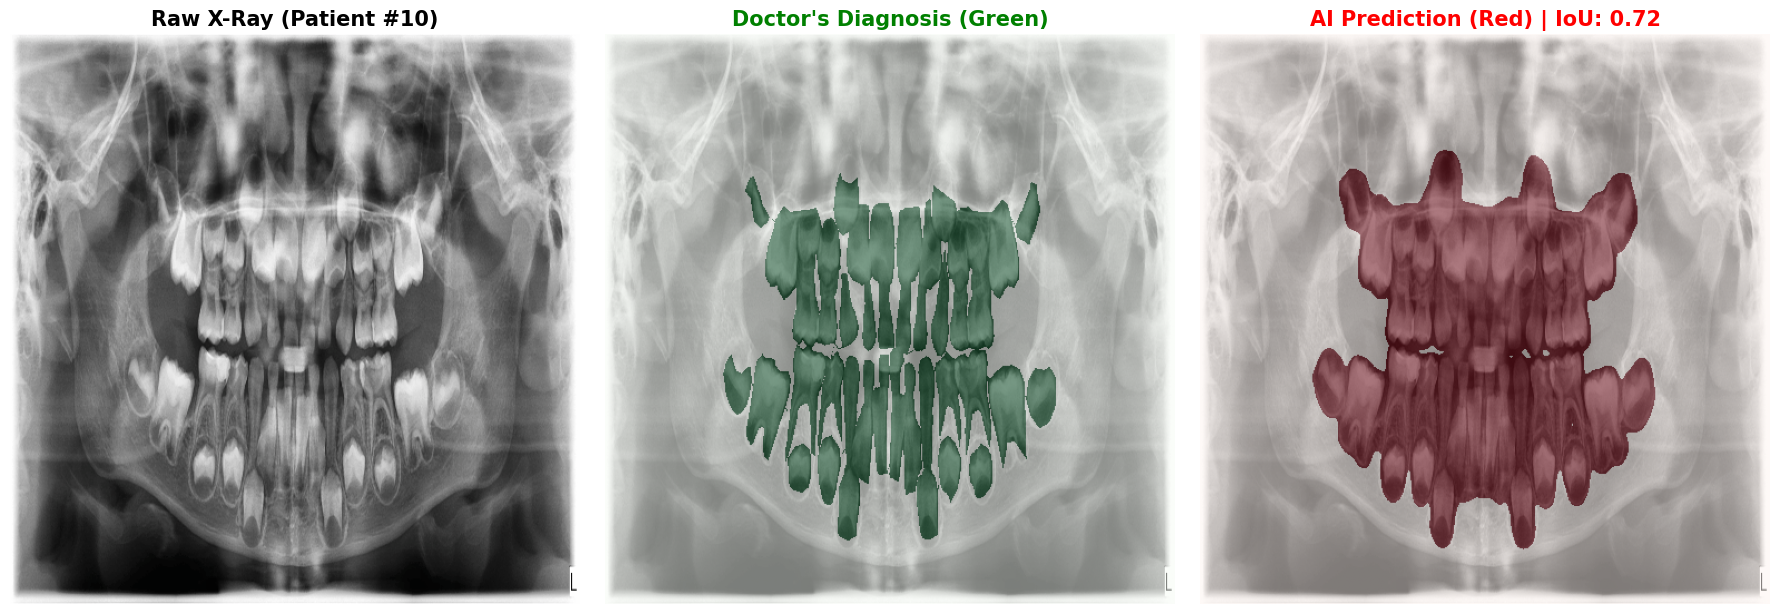

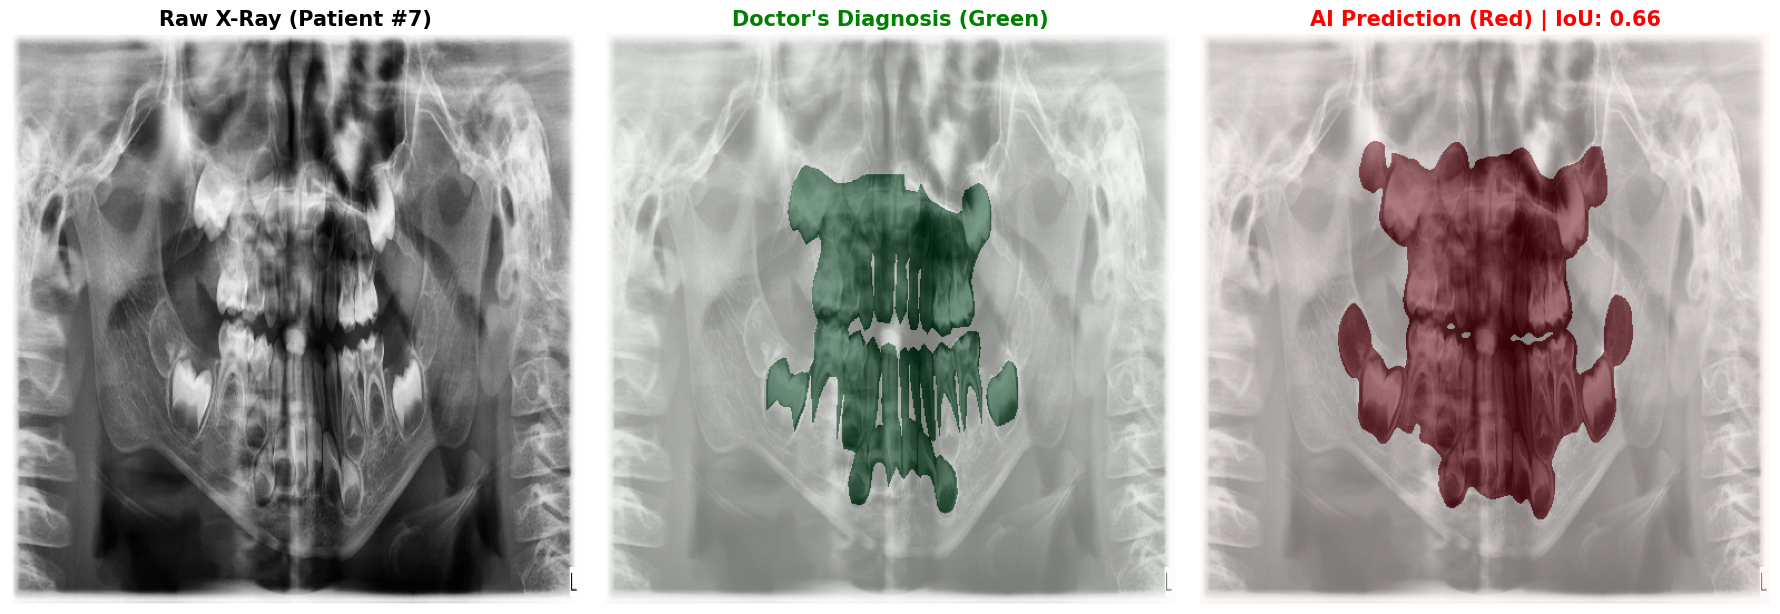

In [67]:

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.cuda.amp import autocast

# 1. Re-create the Test Dataset to make sure it's fresh
# We use val_imgs and val_masks from your DatasetLocator block
test_dataset = DentalCariesDataset(
    val_imgs, 
    val_masks, 
    transform=AugmentationPipeline.get_val_transforms(),
    img_size=(512, 512)
)


print("🔄 Loading the best model")
model = build_model()
checkpoint = torch.load("/kaggle/working/best_model.pth", map_location=Config.DEVICE)
model.load_state_dict(checkpoint['model_state_dict'])
model.to(Config.DEVICE)
model.eval() # Put the brain in 'Exam Mode'

def test_random_patient(model, dataset, threshold=0.5):
    # Pick a random patient from the test set
    idx = np.random.randint(0, len(dataset))
    sample = dataset[idx]
    
    # Get the data ready for the GPU
    image_tensor = sample['image'].unsqueeze(0).to(Config.DEVICE)
    true_mask = sample['mask'].squeeze().numpy()
    
    # 3. AI Prediction
    with torch.no_grad():
        with autocast(): # Use mixed precision just like training
            logits = model(image_tensor)
        # Convert raw numbers to percentages (0 to 1)
        pred_prob = torch.sigmoid(logits).squeeze().cpu().numpy()
        
    # Apply threshold (If AI is > 50% sure, call it a cavity)
    pred_mask = (pred_prob > threshold).astype(np.float32)
    
    # 4. Image Formatting for Display (Undo the PyTorch Normalization)
    img_display = sample['image'].permute(1, 2, 0).numpy()
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    img_display = std * img_display + mean
    img_display = np.clip(img_display, 0, 1)

    # 5. Calculate the Exam Score for this specific image
    intersection = (pred_mask * true_mask).sum()
    union = pred_mask.sum() + true_mask.sum() - intersection
    iou = intersection / (union + 1e-6)


    plt.figure(figsize=(18, 6))
   
    plt.subplot(1, 3, 1)
    plt.imshow(img_display)
    plt.title(f"Raw X-Ray (Patient #{idx})", fontsize=15, fontweight='bold')
    plt.axis('off')
    

    plt.subplot(1, 3, 2)
    plt.imshow(img_display)
    plt.imshow(true_mask, cmap='Greens', alpha=0.5)
    plt.title("Doctor's Diagnosis (Green)", fontsize=15, fontweight='bold', color='green')
    plt.axis('off')
    
  
    plt.subplot(1, 3, 3)
    plt.imshow(img_display)
    plt.imshow(pred_mask, cmap='Reds', alpha=0.5)
    plt.title(f"AI Prediction (Red) | IoU: {iou:.2f}", fontsize=15, fontweight='bold', color='red')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

# --- EXECUTE ---
# Run it 3 times to see 3 different random patients!
for i in range(3):
    test_random_patient(model, test_dataset, threshold=0.5)